In [1]:
import numpy as np
from numpy.linalg import inv
import control
from gyrobro_gym_env import GyrobroBulletEnv
from pyrr import Quaternion
from scipy.spatial.transform import Rotation
# from transforms3d.quaternions import quat2mat
 

pybullet build time: Jul 10 2024 15:33:38


Theoretical Part

In [2]:
Ts = 1/200 #0.002
# Physical constants
g = 9.81                        # gravity acceleration [m/sec**2]
# Physical parameters
m = 0.977						# wheel weight [kg]
hw = 0.045                      # wheel width [m]
R = 0.0795						# wheel radius [m]

Mstator = 0.548
R_stator = 0.0493                # stator radius [m]
hw_stator = 0.02

Jw = (m * R**2 / 2) - (Mstator * R_stator**2 / 2)				# wheel inertia moment [kgm**2]
Jwx = (m * (3*R**2 + hw**2) / 12) - (Mstator * (3*R_stator**2 + hw_stator**2) / 12)   # wheel inertia moment around x and y axes

M = 4.414                       # body weight [kg]
W = 0.37						# body width [m]
D = 0.09					    # body depth [m]
h = 0.4 						# body height [m]
L = h / 2						# distance of the center of mass from the wheel axle [m]
Jpsi = M * L**2 / 3;				# body pitch inertia moment [kgm**2]
Jphi = M * (W**2 + D**2) / 12	    # body yaw inertia moment [kgm**2]
fm = 0.0022					    # friction coefficient between body & DC motor
fw = 0.011           			    # friction coefficient between wheel & floor

# Motors parameters
Jm = 1e-5						# DC motor inertia moment [kgm**2]
Kt = 0.42 #2.7						# DC motor torque constant [Nm/A]
n = 1							# Gear ratio
Rm = 0.4 #0.8
Kb = 0.37

Psi0 = 0.01                     # Initial value to make disturbance
# Ts = 0.01

# g = 9.81                       

# m = 1.54						
# hw = 0.054                     
# R = 0.122						
# Jw = m * R**2 / 2				
# Jwx = m * (3*R**2 + hw**2) / 12  
# M = 7.03                       
# W = 0.42						
# D = 0.2						
# h = 0.39						
# L = h / 2						
# Jpsi = M * L**2 / 3				
# Jphi = M * (W**2 + D**2) / 12	
# fm = 0.0022					
# fw = 0.0           			

# Jm = 1e-5						
# Kt = 1.0					
# n = 1							

# Psi0 = 0.01                   

In [3]:
def nonlinear_dynamics(x, u):
    alpha = n * Kt #n * Kt / Rm
    beta = fm #n * Kt * Kb / Rm + fm

    F_11 = 2*(beta+fw)
    F_12 = -2*beta
    F_21 = -2*beta
    F_22 = 2*beta

    E_11 = (2*m +M) * R**2 + 2 * Jw + 2*n**2*Jm
    E_12 = M*L*R - 2*n**2*Jm
    E_21 = E_12
    E_22 = M*L**2 + Jpsi + 2*n**2*Jm
    detE = E_11*E_22 - E_12*E_21

    I = 0.5*m*W**2 + Jphi + (W**2/(2*R**2))*(Jw + n**2*Jm)
    J = (W**2/(2*R**2))*(beta + fw)
    K = (W/(2*R))*alpha

    eq4 = -E_12*(-F_21*x[3][0] - F_22*x[4][0] + L**2*M*x[6][0]**2*np.sin(x[2][0])*np.cos(x[2][0]) + L*M*g*np.sin(x[2][0]) + alpha*(-u[0][0] - u[1][0]))/detE + E_22*(-F_11*x[3][0] - F_12*x[4][0] + L*M*R*x[4][0]**2*np.sin(x[2][0]) + alpha*(u[0][0] + u[1][0]))/detE
    eq5 = E_11*(-F_21*x[3][0] - F_22*x[4][0] + L**2*M*x[6][0]**2*np.sin(x[2][0])*np.cos(x[2][0]) + L*M*g*np.sin(x[2][0]) + alpha*(-u[0][0] - u[1][0]))/detE - E_21*(-F_11*x[3][0] - F_12*x[4][0] + L*M*R*x[4][0]**2*np.sin(x[2][0]) + alpha*(u[0][0] + u[1][0]))/detE
    eq6 = (-J*x[6][0] + K*(-u[0][0] + u[1][0]) - 2*L**2*M*x[4][0]*x[6][0]*np.sin(x[2][0])*np.cos(x[2][0]))/I

    state = np.array([
                      [x[0][0] + x[1][0]*Ts], 
                      [x[1][0] + x[3][0]*Ts], 
                      [x[2][0] + x[4][0]*Ts], 
                      [x[3][0] + eq4*Ts], 
                      [x[4][0] + eq5*Ts],
                      [x[5][0] + x[6][0]*Ts], 
                      [x[6][0] + eq6*Ts]
                      ] , dtype=float)
    
    jacobian = np.eye(7)

    jacobian[0][1] = Ts
    jacobian[1][3] = Ts
    jacobian[2][4] = Ts
    jacobian[5][6] = Ts

    jacobian[3][2] = -Ts*L*M*(E_12*(-2*L*state[6][0]**2*np.sin(state[2][0])**2 + L*state[6][0]**2 + g*np.cos(state[2][0])) - E_22*R*state[4][0]**2*np.cos(state[2][0]))/detE
    jacobian[3][3] = (Ts*(E_12*F_21 - E_22*F_11) + detE)/detE
    jacobian[3][4] = Ts*(E_12*F_22 - E_22*(F_12 - 2*L*M*R*state[4][0]*np.sin(state[2][0])))/detE
    jacobian[3][6] = -Ts*E_12*L**2*M*state[6][0]*np.sin(2*state[2][0])/detE
    jacobian[4][2] = Ts*L*M*(E_11*(-2*L*state[6][0]**2*np.sin(state[2][0])**2 + L*state[6][0]**2 + g*np.cos(state[2][0])) - E_21*R*state[4][0]**2*np.cos(state[2][0]))/detE
    jacobian[4][3] = Ts*(-E_11*F_21 + E_21*F_11)/detE
    jacobian[4][4] = (-Ts*(E_11*F_22 - E_21*(F_12 - 2*L*M*R*state[4][0]*np.sin(state[2][0]))) + detE)/detE
    jacobian[4][6] = Ts*E_11*L**2*M*state[6][0]*np.sin(2*state[2][0])/detE

    jacobian[6][2] = -2*Ts*L**2*M*state[4][0]*state[6][0]*np.cos(2*state[2][0])/I
    jacobian[6][4] = -Ts*L**2*M*state[6][0]*np.sin(2*state[2][0])/I
    jacobian[6][6] = (-Ts*(J + L**2*M*state[4][0]*np.sin(2*state[2][0])) + I)/I

    return state, jacobian

# x = np.array([[0], [1], [2], [3], [0], [0], [0]], dtype=float)
# u = np.array([[0], [0]], dtype=float)
# a, b = nonlinear_dynamics(x, u)
# print(a)
# print(b)

In [4]:
x = np.array([[0], [0], [0], [0], [0], [0], [0]], dtype=float)
u = np.array([[0], [0]], dtype=float)

x_, j = nonlinear_dynamics(x, u)
print(j)
print("-----")

x = np.array([[1], [2], [3], [4], [5], [6], [7]], dtype=float)
u = np.array([[8], [9]], dtype=float)

x_, j = nonlinear_dynamics(x, u)
print(x_)
print(j)

[[ 1.          0.005       0.          0.          0.          0.
   0.        ]
 [ 0.          1.          0.          0.005       0.          0.
   0.        ]
 [ 0.          0.          1.          0.          0.005       0.
   0.        ]
 [ 0.          0.         -0.53322269  0.99427473  0.00117997  0.
  -0.        ]
 [ 0.          0.          0.34283009  0.00179966  0.99955491  0.
   0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.005     ]
 [ 0.          0.         -0.          0.         -0.          0.
   0.99512234]]
-----
[[1.01      ]
 [2.02      ]
 [3.025     ]
 [5.94809938]
 [4.26799491]
 [6.035     ]
 [7.0581158 ]]
[[ 1.          0.005       0.          0.          0.          0.
   0.        ]
 [ 0.          1.          0.          0.005       0.          0.
   0.        ]
 [ 0.          0.          1.          0.          0.005       0.
   0.        ]
 [ 0.          0.         -0.25963723  0.99427473  0.01557822  0.
   0.01773032]
 [ 

In [5]:
# Helping variables
alpha = n * Kt / Rm #n * Kt # 
beta = n * Kt * Kb / Rm + fm# fm# 

E = np.array ([[(2*m+M)*R**2 + 2*Jw + 2*n**2*Jm,   M*L*R - 2*n**2*Jm],
               [M*L*R - 2*n**2*Jm,                 M*L**2 + Jpsi + 2*n**2*Jm]], dtype=float)
F = np.array ([[beta+fw,   -beta],
                 [-beta,      beta]], dtype=float)*2
G = np.array ([[0,   0],
               [0,  -M*g*L]], dtype=float)
H = np.array ([[alpha,    alpha],
               [-alpha,  -alpha]], dtype=float)
I = m * W**2 / 2 + Jphi + (Jw + n**2 * Jm) * W**2 / (2 * R**2)
J = W**2 / (2 * R**2) * (beta + fw)
K = W / (2 * R) * alpha

In [6]:
# State Space Matrices
A1 = np.array([[0, 0,   1, 0],
	            [0, 0,   0, 1],
               [0, 0,   0, 0],
               [0, 0,   0, 0]], dtype=float)
            #    [-inv(E)*G,  -inv(E)*F]]) 
A1[2:4, 0:2] = np.matmul(-inv(E), G)
A1[2:4, 2:4] = np.matmul(-inv(E), F)

B1 = np.array([[0, 0],
	            [0, 0],
               [0, 0],
			      [0, 0]], dtype=float)
B1[2:4, 0:2] = np.matmul(inv(E), H)
C1 = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]], dtype=float)
D1 = np.zeros((4, 2))
A2 = np.array([[0,  1],
	            [0,  -J/I]], dtype=float)
B2 = np.array([[0,    0],
	            [-K/I,  K/I]], dtype=float)
C2 = np.array([[1, 0],
               [0, 1]], dtype=float)
D2 = np.zeros((2,2))

In [7]:
# State space models
s1 = control.ss(A1, B1, C1, D1)
s1.set_states =  ['theta', 'psi', 'theta_dot', 'psi_dot']
s1.set_inputs =  ['il', 'ir']
s1.set_outputs = ['theta', 'psi', 'theta_dot', 'psi_dot']
s2 = control.ss(A2, B2, C2, D2)
s2.set_states(['phi', 'phi_dot'])
s2.set_inputs(['il', 'ir'])
s2.set_outputs(['phi', 'phi_dot'])

# Add a fifth state - integral of theta
s0 = control.tf2ss([1], [1,0])
s0.set_states = 'theta_int'
s0.set_outputs = 'theta_int'
s3 = control.append(s0, s1)
s3.A[0, 1] = 1
s3.B = s3.B[:, 1:]
s3.D = s3.D[:, 1:]
s3.set_inputs(['il', 'ir'])

# Add phi and phi_dot states (from s2 system)
s4 = control.append(s3, s2)
s4.B[-1, 0:2] = s4.B[-1, 2:4]
s4.B = s4.B[:, 0:2]
s4.D = s4.D[:, 0:2]
s4.set_inputs(['il', 'ir'])

# Convert s4 to discrete-time domain
s5 = control.sample_system(s4, Ts, method='bilinear')
print(s5.isdtime())

Ad = np.eye(7) + s4.A * Ts
Bd = s4.B * Ts

True


In [8]:
# Define Optimality Criteria
QQ = np.array([ [0.05,     0,     0,     0,     0,     0,     0],
                [0,     1.0,     0,     0,     0,     0,     0],
                [0,     0,     10.0,     0,     0,     0,     0],
                [0,     0,     0,     1.0,    0,     0,     0],
                [0,     0,     0,     0,     1.0,     0,     0],
                [0,     0,     0,     0,     0,     1000000,  0],
                [0,     0,     0,     0,     0,     0,     100000]])
RR = np.array([[20000,    0],
               [0,     20000]])

# Get K
K_lqr = control.dlqr(s5.A, s5.B, QQ, RR)[0]
print(f"{K_lqr[0][0]:.3f} | {K_lqr[0][1]:.3f} | {K_lqr[0][2]:.3f} | {0.5*K_lqr[0][3]:.3f} | {K_lqr[0][4]:.3f} | {K_lqr[0][5]:.3f} | {K_lqr[0][6]:.3f}")

K_lqr = control.lqr(s4.A, s4.B, QQ, RR)[0]
print(f"{K_lqr[0][0]:.3f} | {K_lqr[0][1]:.3f} | {K_lqr[0][2]:.3f} | {0.5*K_lqr[0][3]:.3f} | {K_lqr[0][4]:.3f} | {K_lqr[0][5]:.3f} | {K_lqr[0][6]:.3f}")

# K_lqr = np.array([[-0.0635,   -0.2134,   -9.9954,   -0.3287,   -1.5106,   -2.1280,   -0.9244],
#                   [-0.0635,   -0.2134,   -9.9954,   -0.3287,   -1.5106,    2.1280,    0.9244,]])
# print(K_lqr)

-0.001 | -0.029 | -14.354 | -0.366 | -2.174 | -4.599 | -0.865
-0.001 | -0.030 | -14.534 | -0.371 | -2.201 | -5.000 | -1.005


In [9]:
for i in range(0, 7):
    for k in range(0, 2):
        print(f"{s5.B[i][k]:.3f}", end=" ")
    print("")


0.000 0.000 
0.001 0.001 
-0.000 -0.000 
0.246 0.246 
-0.093 -0.093 
-0.000 0.000 
-0.078 0.078 


Practical part

In [10]:
theta_l = 0
theta_r = 0
i_theta = 0
theta = 0
pre_theta = 0
psi = 0
d_theta = 0
d_psi = 0 
phi = 0
pre_phi = 0
d_phi = 0

real_theta_l = 0
real_theta_r = 0
real_i_theta = 0
real_theta = 0
real_pre_theta = 0
real_psi = 0
real_d_theta = 0
real_d_psi = 0
real_phi = 0
real_pre_phi = 0
real_d_phi = 0

ref_i_theta = 0
ref_theta = 0
ref_d_theta = 0
ref_psi = 0
ref_d_psi = 0
ref_phi = 0
ref_d_phi = 0
ref_x = np.array([  [0],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0]], dtype=float)


u = np.zeros((2,1))
action = [0.0, 0.0]

env = GyrobroBulletEnv(render=True, 
                       sim_freq=1/Ts, 
                       on_rack=False,
                       initial_pitch=0.02,
                       simple_motor_model_enabled=True,
                       observation_noise_stdev=[0.0, 0.0, 0.0, 0.0, 0.0])
                      #  observation_noise_stdev=[0.00062, 0.0, 0.0008, 0.0, 0.00057])

argv[0]=--width=2280
argv[1]=--height=1500
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=4
argv[0] = --unused
argv[1] = --width=2280
argv[2] = --height=1500
argv[3] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.183.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.183.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
/home/yoggi/gyrobro_ws/src/gyrobro_sim

In [11]:
class LinearKalmanFilter():
    def __init__(self, dim_x : int, dim_u : int, dim_z : int) -> None:
        
        self.F = np.zeros((dim_x, dim_x), dtype=float)
        self.G = np.zeros((dim_x, dim_u), dtype=float)
        self.H = np.zeros((dim_z, dim_x), dtype=float)
        self.R = np.zeros((dim_z, dim_z), dtype=float)
        self.Q = np.zeros((dim_x, dim_x), dtype=float)
        
        self.P = np.zeros((dim_x, dim_x), dtype=float)
        self.P_ = np.zeros((dim_x, dim_x), dtype=float)

        self.I = np.eye(dim_x)
        self.x_hat = 0
        self.x_ = 0

    def set_dynamics(self, F, G):
        self.F = F
        self.G = G

    def set_measurement_matrix(self, H):
        self.H = H

    def set_noise(self, R, Q):
        self.R = R
        self.Q = Q

    def set_initial_estimate(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        # extrapolate the state
        self.x_ = self.F @ self.x_hat + self.G @ u
        # extrapolate uncertainty
        self.P_ = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        # compute the Kalman Gain
        K = self.P_ @ self.H.T @ np.linalg.inv(self.H @ self.P_ @ self.H.T + self.R)
        # update estimate with measurement
        self.x_hat = self.x_ + K @ (z - self.H @ self.x_)
        # update the estimate uncertainty
        self.P = (self.I - K @ self.H) @ self.P_ @ ((self.I - K @ self.H).T) + K @ self.R @ K.T 
        return self.x_hat, K
    
    def step(self, z):
        self.predict()
        self.update(z)
        return self.x_hat

In [12]:
class ExtendedKalmanFilter():
    def __init__(self, dim_x : int, dim_u : int, dim_z : int) -> None:
        self.H = np.zeros((dim_z, dim_x), dtype=float)
        self.R = np.zeros((dim_z, dim_z), dtype=float)
        self.Q = np.zeros((dim_x, dim_x), dtype=float)
        
        self.P = np.zeros((dim_x, dim_x), dtype=float)
        self.P_ = np.zeros((dim_x, dim_x), dtype=float)

        self.I = np.eye(dim_x)
        self.x_hat = 0
        self.x_ = 0
        self.dfdx = np.zeros((dim_x, dim_x), dtype=float)

    def set_dynamics(self, dynamics):
        self.dynamics = dynamics

    def set_measurement_matrix(self, H):
        self.H = H

    def set_noise(self, R, Q):
        self.R = R
        self.Q = Q

    def set_initial_estimate(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        self.x_, self.dfdx = self.dynamics(self.x_hat, u)
        self.P_ = self.dfdx @ self.P @ (self.dfdx.T) + self.Q

    def update(self, z):
        # compute the Kalman Gain
        K = self.P_ @ self.H.T @ np.linalg.inv(self.H @ self.P_ @ self.H.T + self.R)
        # update estimate with measurement
        self.x_hat = self.x_ + K @ (z - self.H @ self.x_)
        # update the estimate uncertainty
        self.P = (self.I - K @ self.H) @ self.P_ @ ((self.I - K @ self.H).T) + K @ self.R @ K.T 
        return self.x_hat

    def step(self, z):
        self.predict()
        self.update(z)
        return self.x_hat

In [13]:
class UnscentedKalmanFilter():
    def __init__(self, dim_x : int, 
                       dim_u : int, 
                       dim_z : int,
                       kappa=0.0,
                       alpha=0.1,
                       beta=2
                       ) -> None:
        self.dim_x = dim_x
        self.dim_z = dim_z
        
        self.kappa = kappa
        self.alpha = alpha
        self.beta = beta

        self.H = np.zeros((dim_z, dim_x), dtype=float)
        self.R = np.zeros((dim_z, dim_z), dtype=float)
        self.Q = np.zeros((dim_x, dim_x), dtype=float)
        
        self.P = np.zeros((dim_x, dim_x), dtype=float)
        self.P_ = np.zeros((dim_x, dim_x), dtype=float)

        self.chi = np.zeros((dim_x, 2*dim_x+1), dtype=float)
        self.chi_ = np.zeros((dim_x, 2*dim_x+1), dtype=float)
        self.Z = np.zeros((dim_z, 2*dim_x+1), dtype=float)

        # self.I = np.eye(dim_x)
        self.x_hat = 0
        self.x_ = 0
        # self.dfdx = np.zeros((dim_x, dim_x), dtype=float)

        self.lamba, self.w_m, self.w_c = self.init_sigma_params(dim_x, self.kappa, self.alpha, self.beta)
        self.N = dim_x

    def init_sigma_params(self, dim_x, kappa, alpha, beta):
        N = dim_x
        lamba = alpha**2 * (N + kappa) - N
        # print(lamba)
        
        w0_m = lamba/(N + lamba)
        # print(w0_m)
        w0_c = lamba/(N + lamba) + 1 - alpha**2 + beta
        wi = 1/(2*(N + lamba))
        # print(wi)

        w_m = wi * np.ones((1, 2*N+1))
        w_m[0][0] = w0_m
        # print(w_m)
        # print(w0_m)

        w_c = np.diag((wi * np.ones((1, 2*N+1)))[0])
        w_c[0][0] = w0_c

        return lamba, w_m.reshape(2*N+1, 1), w_c


    def set_dynamics(self, dynamics):
        self.dynamics = dynamics

    def set_measurement_matrix(self, H):
        self.H = H

    def set_noise(self, R, Q):
        self.R = R
        self.Q = Q

    def set_initial_estimate(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        # sigma transform
        self.chi[:,0] = self.x_hat.reshape(self.dim_x,)
        L_sqrt = np.linalg.cholesky((self.N + self.lamba) * self.P)
        for i in range(1, 2*self.N+1):
            if i <= self.N:
                self.chi[:,i] = (self.x_hat + L_sqrt[:,i-1].reshape(self.dim_x,1)).reshape(self.dim_x,)
            else:
                self.chi[:,i] = (self.x_hat - L_sqrt[:,i-self.N-1].reshape(self.dim_x,1)).reshape(self.dim_x,)
        
        # propagation through non-linear function
        for i in range(2*self.N+1):
            state, dfdx = self.dynamics(self.chi[:,i].reshape(self.dim_x,1), u)
            self.chi_[:,i] = state.reshape(self.dim_x,)

        # mean and covariance computation
        # print(self.chi_)
        # print(self.w_m)
        self.x_hat_ = self.chi_ @ (self.w_m)
        self.P_ = (self.chi_ - self.x_hat_) @ self.w_c @ ((self.chi_ - self.x_hat_).T) + self.Q
        # print(self.chi_ - self.x_hat_)


    def update(self, z):
        # propagate through observation matrix
        for i in range(2*self.N+1):
            self.Z[:,i] = (self.H @ self.chi_[:,i].reshape(self.dim_x, 1)).reshape(self.dim_z, )
        # mean and cross-covariance computation
        mu_z = self.Z @ (self.w_m)
        Pz = (self.Z - mu_z) @ self.w_c @ ((self.Z - mu_z).T) + self.R
        Pxz = (self.chi_ - self.x_hat_) @ self.w_c @ ((self.Z - mu_z).T)
        # Kalman Gain computation
        K = Pxz @ np.linalg.inv(Pz)
        # estimate state and new covariance
        self.x_hat = self.x_hat_ + K @ (z - mu_z)
        self.P = self.P_ - K @ Pz @ (K.T)

        return self.x_hat


    def step(self, z):
        self.predict()
        self.update(z)
        return self.x_hat

In [14]:
# LKF and EKF Params
dim_x = 7
dim_y = 5
dim_u = 2

x0 = np.array([[0], [0], [0], [0], [0], [0], [0]], dtype=float)
P0 = np.eye(dim_x) * 0.1
H_lkf = np.array([[0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1]])
sigma = [2, 
        2, 
        0.05, 
        0.1, 
        0.02]; # variance of measurements [theta psi d_theta d_psi phi d_phi]
Q_lkf = np.array([[Ts**4/4,     Ts**3/2,     0,          Ts**2/2,     0,          0,          0],
                  [Ts**3/2,     10*Ts**2,       0,          Ts,         0,          0,          0],
                  [0,          0,          1,       0,             Ts,         0,          0],
                  [Ts**2/2,     Ts,         0,          4000,        0,          0,          0],
                  [0,          0,          Ts,         0,          100,         0,          0],
                  [0,          0,          0,          0,          0,          Ts**2,       Ts],
                  [0,          0,          0,          0,          0,          Ts,         1]])

R_lkf = np.array([[sigma[0],   0,          0,          0,          0],
                  [0,          sigma[1],   0,          0,          0],
                  [0,          0,          sigma[2],   0,          0],
                  [0,          0,          0,          sigma[3],   0],
                  [0,          0,          0,          0,          sigma[4]]])

# UKF Params
kappa_ukf = 0.0 #3 - N # tuning parameter
alpha_ukf = 0.1 # tuning parameter. The higher alpha the higher spread of sigma points
beta_ukf = 2.0 # Gaussian distribution

sigma_y_ukf  = [2, 
            0.1, 
            0.05, 
            0.1, 
            0.02]; # variance of measurements [theta psi d_theta d_psi phi d_phi]

# Q_ukf = np.array([  [0.00025*Ts**4,  Ts**3/2,      0,          Ts**2/2,     0,          0,            0],
#                     [Ts**3/2,       1*Ts**2,       0,          0.01*Ts,     0,          0,            0],
#                     [0,             0,            70,         0,           0*Ts,       0,            0],
#                     [Ts**2,         0.01*Ts,      0,          1000,         0,          0,            0],
#                     [0,             0,            0*Ts,       0,           50,         0,            0],
#                     [0,             0,            0,          0,           0,          100*Ts**2,    50*Ts],
#                     [0,             0,            0,          0,           0,          50*Ts,        50]])*0.02
Q_ukf = np.array([[Ts**4/4,    Ts**3/2,    0,       Ts**2/2,     0,          0,          0],
                  [Ts**3/2,    10*Ts**2,   0,       Ts,         0,          0,          0],
                  [0,          0,          1,       0,             Ts,         0,          0],
                  [Ts**2/2,    Ts,         0,       1000,        0,          0,          0],
                  [0,          0,          Ts,      0,          100,         0,          0],
                  [0,          0,          0,       0,          0,          4*Ts**2,       Ts],
                  [0,          0,          0,       0,          0,          Ts,         1]])
# Q_ukf = np.eye(7)*10

R_ukf = np.array([  [sigma_y_ukf[0], 0,              0,              0,              0],
                    [0,              sigma_y_ukf[1], 0,              0,              0],
                    [0,              0,              sigma_y_ukf[2], 0,              0],
                    [0,              0,              0,              sigma_y_ukf[3], 0],
                    [0,              0,              0,              0,              sigma_y_ukf[4]]])

In [15]:
# create LKF
lkf = LinearKalmanFilter(dim_x, dim_u, dim_y)
lkf.set_dynamics(Ad, Bd)
# lkf.set_dynamics(s5.A, s5.B)
lkf.set_initial_estimate(x0, P0)
lkf.set_measurement_matrix(H_lkf)
lkf.set_noise(R_lkf, Q_lkf)

# create EKF
ekf = ExtendedKalmanFilter(dim_x, dim_u, dim_y)
ekf.set_dynamics(nonlinear_dynamics)
ekf.set_initial_estimate(x0, P0)
ekf.set_measurement_matrix(H_lkf)
ekf.set_noise(R_lkf, Q_lkf)

# create UKF

ukf = UnscentedKalmanFilter(dim_x, 
                            dim_u, 
                            dim_y,
                            kappa_ukf,
                            alpha_ukf,
                            beta_ukf
                            )
ukf.set_dynamics(nonlinear_dynamics)
ukf.set_initial_estimate(x0, P0)
ukf.set_measurement_matrix(H_lkf)
ukf.set_noise(R_ukf, Q_ukf)

In [16]:
# data for analysis
ref_lin_vel_vector = []
ref_yaw_vel_vector = []
ref_psi_vector = []
ref_d_psi_vector = []
i_theta_vector = []
lin_veLvector = []
dyaw_vector = []
yaw_vector = []
ref_yaw_vector = []
psi_vector = []
dpsi_vector = []
u_vector = [[],[]]
t_vector = []
theta_vector = []
x_hat_lkf_vector = [[],[],[],[],[],[],[]]
x_hat_ekf_vector = [[],[],[],[],[],[],[]]
x_hat_ukf_vector = [[],[],[],[],[],[],[]]
K_lkf_vector = []
lkf_abs_err_vector = [[],[],[],[],[],[],[]]
ekf_abs_err_vector = [[],[],[],[],[],[],[]]
ukf_abs_err_vector = [[],[],[],[],[],[],[]]
t = 0
real_x_vector = [[],[],[],[],[],[],[]]


In [17]:
print("ukf")
u = np.array([[0.1], 
              [-0.1]], dtype=float)
z = np.array([  [0.1],
                [0.2],
                [0.3],
                [0.4],
                [0.5]], dtype=float)

for i in range(10):
    ukf.predict([[ u[0][0]], 
                [-u[1][0]]])
    x_hat_ukf = ukf.update(z)

    print(f"i={i}")
    print(x_hat_ukf)
    print("-----")

ukf
i=0
[[ 2.38091185e-05]
 [ 4.76352585e-03]
 [ 1.30562860e-01]
 [-4.59955212e-02]
 [ 2.12033603e-01]
 [ 2.01045479e-01]
 [ 4.16151676e-01]]
-----
i=1
[[9.05712308e-05]
 [9.96055218e-03]
 [1.94111839e-01]
 [3.23307692e-01]
 [2.99957973e-01]
 [2.69380177e-01]
 [4.98581827e-01]]
-----
i=2
[[2.03431460e-04]
 [2.00047468e-02]
 [1.99673175e-01]
 [1.15567746e+00]
 [2.99972170e-01]
 [3.04010744e-01]
 [5.00120599e-01]]
-----
i=3
[[3.89134106e-04]
 [3.80046615e-02]
 [2.00141632e-01]
 [2.25893195e+00]
 [2.99970364e-01]
 [3.25307547e-01]
 [5.00108826e-01]]
-----
i=4
[[6.70208273e-04]
 [6.16905141e-02]
 [2.00179961e-01]
 [3.28092020e+00]
 [2.99970974e-01]
 [3.39938964e-01]
 [5.00079782e-01]]
-----
i=5
[[1.03349068e-03]
 [8.48655143e-02]
 [2.00182561e-01]
 [3.90244208e+00]
 [2.99971456e-01]
 [3.50759822e-01]
 [5.00057844e-01]]
-----
i=6
[[1.44434115e-03]
 [1.02900326e-01]
 [2.00182718e-01]
 [4.06863877e+00]
 [2.99971555e-01]
 [3.59197356e-01]
 [5.00040714e-01]]
-----
i=7
[[1.87668764e-03]
 [1.1482

In [18]:
ref_lin_vel = 1.0
ref_yaw_vel = 0.0

for i in range(3500):

        obs, rew, done, info = env.step(action)
        

        # get sensor states
        phi_tmp = ((2*np.pi - obs[5] - pre_phi) % (2*np.pi))
        if phi_tmp > np.pi:
                phi += (phi_tmp - 2*np.pi)
        else:
                phi += phi_tmp
        pre_phi = phi

        theta_l = -obs[0]
        theta_r = obs[1]
        psi = -obs[4]
        d_psi = -obs[6]
        d_phi = -obs[7]

        theta = 0.5 * (theta_l + theta_r) + psi
        i_theta += (theta*Ts)
        d_theta = (theta - pre_theta) / Ts
        pre_theta = theta
        
        x = np.array([[i_theta],
                      [theta],
                      [psi],
                      [d_theta],
                      [d_psi],
                      [phi],
                      [d_phi]], dtype=float)
        
        lin_vel = d_theta#0.471*d_theta/np.pi

        # get real state
        real_obs = env.get_real_observation()
        real_phi_tmp = ((2*np.pi - real_obs[5] - real_pre_phi) % (2*np.pi))
        if real_phi_tmp > np.pi:
                real_phi += (real_phi_tmp - 2*np.pi)
        else:
                real_phi += real_phi_tmp
        real_pre_phi = real_phi

        real_theta_l = -real_obs[0]
        real_theta_r = real_obs[1]
        real_psi = -real_obs[4]
        real_d_psi = -real_obs[6]
        real_d_phi = -real_obs[7]

        real_theta = 0.5 * (real_theta_l + real_theta_r) + real_psi
        real_i_theta += (real_theta*Ts)
        real_d_theta = (real_theta - real_pre_theta) / Ts
        real_pre_theta = real_theta
        
        real_x = np.array([[real_i_theta],
                        [real_theta],
                        [real_psi],
                        [real_d_theta],
                        [real_d_psi],
                        [real_phi],
                        [real_d_phi]], dtype=float)
        
        # set reference state
        ref_d_theta = ref_lin_vel#*np.pi/0.471
        ref_theta += (ref_d_theta*Ts)
        ref_i_theta += (ref_theta*Ts)
        ref_d_psi = 0
        ref_psi = 0
        ref_d_phi = ref_yaw_vel
        ref_phi += (ref_d_phi*Ts)
        ref_x = np.array([[ref_i_theta],
                        [ref_theta],
                        [ref_psi],
                        [ref_d_theta],
                        [ref_d_psi],
                        [ref_phi],
                        [ref_d_phi]], dtype=float)
        
        # Linear Kalman Filter
        z = np.array([  [theta],
                        [psi],
                        [d_psi],
                        [phi],
                        [d_phi]], dtype=float)
        lkf.predict([[ u[0][0]], 
                    [-u[1][0]]])
        x_hat_lkf, K_lkf = lkf.update(z)
        

        # Extended Kalman Filter
        ekf.predict([[ u[0][0]], 
                    [-u[1][0]]])
        x_hat_ekf = ekf.update(z)

        # Unscented Kalman Filter
        ukf.predict([[ u[0][0]], 
                    [-u[1][0]]])
        x_hat_ukf = ukf.update(z)

        # calculate error
        e = ref_x - real_x#x_hat_ukf

        # LQR
        u = np.matmul(K_lqr, e)
        action = [-u[0][0], u[1][0]]
        # action = [-Kt*u[0][0], Kt*u[1][0]]
        # action = [0.0]*2
        # action = [-1.0, -1.0]
        action = np.clip(action, -20.0, 20.0)
        
        # save data
        for i in range(dim_x):
                x_hat_lkf_vector[i].append(x_hat_lkf[i])
                x_hat_ekf_vector[i].append(x_hat_ekf[i])
                x_hat_ukf_vector[i].append(x_hat_ukf[i])
                real_x_vector[i].append(real_x[i][0])
        K_lkf_vector.append(K_lkf[2][1])
        psi_vector.append(psi)
        ref_lin_vel_vector.append(ref_lin_vel)
        ref_yaw_vel_vector.append(ref_yaw_vel)
        ref_psi_vector.append(ref_psi)
        ref_d_psi_vector.append(ref_d_psi)
        i_theta_vector.append(i_theta)
        lin_veLvector.append(lin_vel)
        dyaw_vector.append(d_phi)
        yaw_vector.append(phi)
        ref_yaw_vector.append(ref_phi)
        dpsi_vector.append(d_psi)
        theta_vector.append(theta)
        u_vector[0].append(u[0][0])
        u_vector[1].append(-u[1][0])
        t_vector.append(t)

        # increment current time step
        t += Ts


/home/yoggi/gyrobro_ws/src/gyrobro_sim/urdf/gyrobro.urdf


In [19]:
K_lkf

array([[ 3.53544876e-03,  1.76227417e-05, -1.06998464e-04,
         0.00000000e+00,  0.00000000e+00],
       [ 2.92937131e-01, -3.52457507e-03,  2.14010309e-02,
         0.00000000e+00,  0.00000000e+00],
       [-3.52457507e-03,  4.99888899e-01,  1.06946649e-03,
         0.00000000e+00,  0.00000000e+00],
       [ 1.04869699e+01, -4.60136814e-01,  2.57849540e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.35025773e-04,  2.67366624e-05,  9.99632567e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.56336851e-03,  4.98456893e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.96913786e-04,  9.80656823e-01]])

Text(0.5, 1.0, '$d\\phi$')

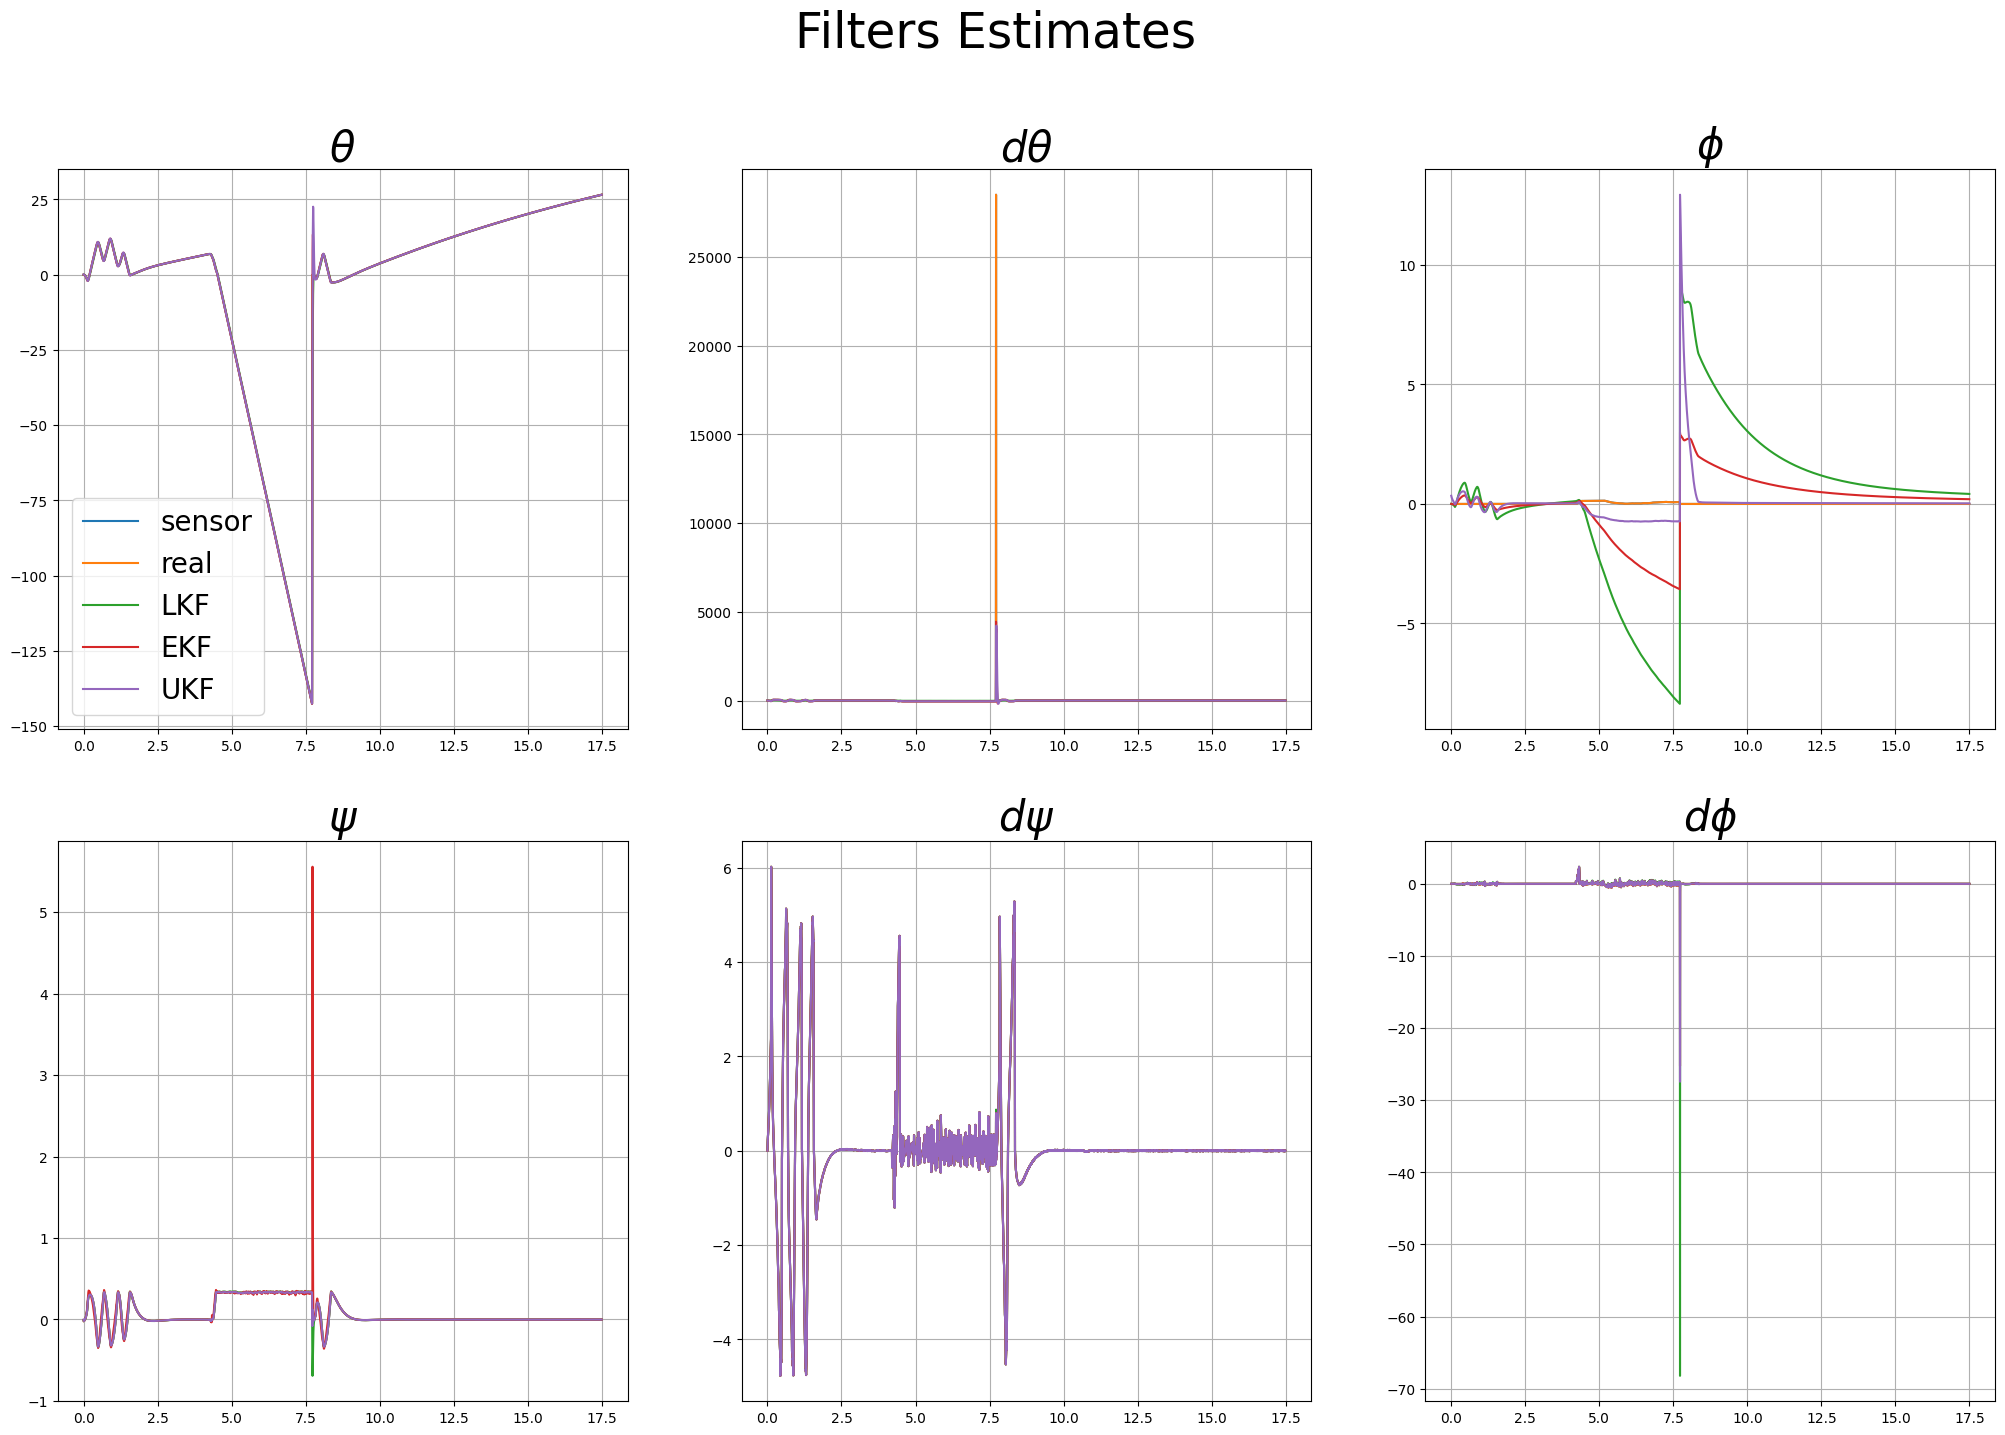

In [20]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 16))
fig.suptitle('Filters Estimates', fontsize="35")

ax1.plot(t_vector, theta_vector, label="sensor")
ax1.plot(t_vector, real_x_vector[1], label="real")
ax1.plot(t_vector, x_hat_lkf_vector[1], label="LKF")
ax1.plot(t_vector, x_hat_ekf_vector[1], label="EKF")
ax1.plot(t_vector, x_hat_ukf_vector[1], label="UKF")
ax1.grid()
ax1.set_title(r'$\theta$', fontsize="30")
ax1.legend(fontsize="20")
# ax1.rc('xtick', labelsize=15)

ax2.plot(t_vector, lin_veLvector, label="sensor")
ax2.plot(t_vector, real_x_vector[3], label="real")
ax2.plot(t_vector, x_hat_lkf_vector[3], label="LKF")
ax2.plot(t_vector, x_hat_ekf_vector[3], label="EKF")
ax2.plot(t_vector, x_hat_ukf_vector[3], label="UKF")
ax2.grid()
ax2.set_title(r'$d\theta$', fontsize="30")

ax3.plot(t_vector, yaw_vector, label="sensor")
ax3.plot(t_vector, real_x_vector[5], label="real")
ax3.plot(t_vector, x_hat_lkf_vector[5], label="LKF")
ax3.plot(t_vector, x_hat_ekf_vector[5], label="EKF")
ax3.plot(t_vector, x_hat_ukf_vector[5], label="UKF")
ax3.grid()
ax3.set_title(r'$\phi$', fontsize="30")

ax4.plot(t_vector, psi_vector, label="sensor")
ax4.plot(t_vector, real_x_vector[2], label="real")
ax4.plot(t_vector, x_hat_lkf_vector[2], label="LKF")
ax4.plot(t_vector, x_hat_ekf_vector[2], label="EKF")
ax4.plot(t_vector, x_hat_ukf_vector[2], label="UKF")
ax4.grid()
ax4.set_title(r'$\psi$', fontsize="30")

ax5.plot(t_vector, dpsi_vector, label="sensor")
ax5.plot(t_vector, real_x_vector[4], label="real")
ax5.plot(t_vector, x_hat_lkf_vector[4], label="LKF")
ax5.plot(t_vector, x_hat_ekf_vector[4], label="EKF")
ax5.plot(t_vector, x_hat_ukf_vector[4], label="UKF")
ax5.grid()
ax5.set_title(r'$d\psi$', fontsize="30")

ax6.plot(t_vector, dyaw_vector, label="sensor")
ax6.plot(t_vector, real_x_vector[6], label="real")
ax6.plot(t_vector, x_hat_lkf_vector[6], label="LKF")
ax6.plot(t_vector, x_hat_ekf_vector[6], label="EKF")
ax6.plot(t_vector, x_hat_ukf_vector[6], label="UKF")
ax6.grid()
ax6.set_title(r'$d\phi$', fontsize="30")


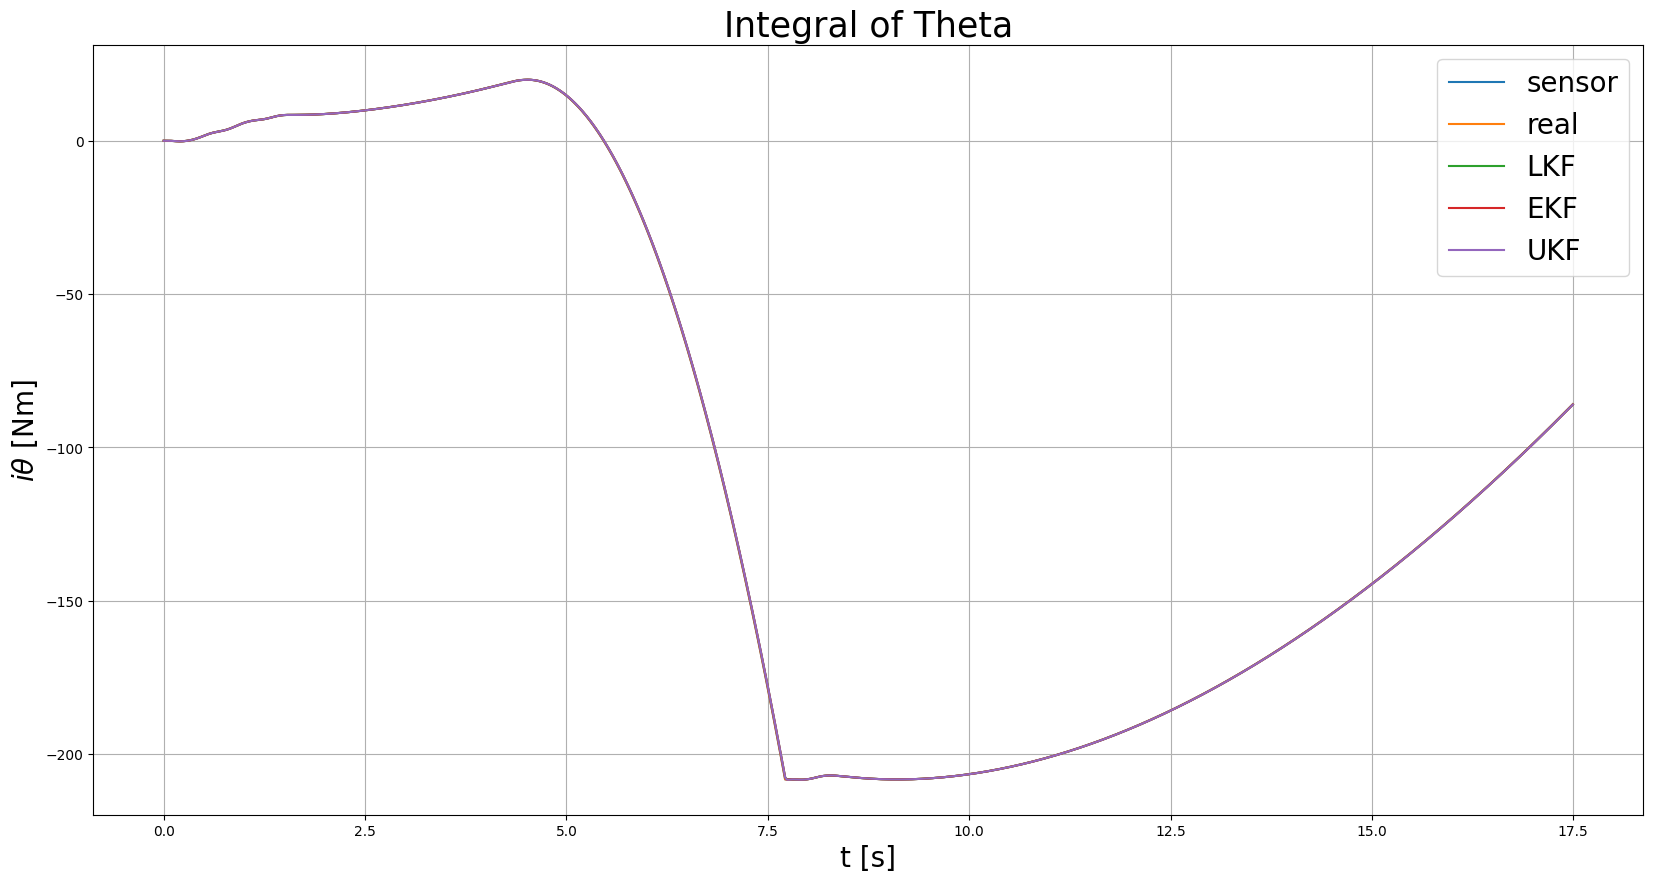

In [21]:
plt.figure(figsize=(20,10))
plt.plot(t_vector, i_theta_vector, label="sensor")
plt.plot(t_vector, real_x_vector[0], label="real")
plt.plot(t_vector, x_hat_lkf_vector[0], label="LKF")
plt.plot(t_vector, x_hat_ekf_vector[0], label="EKF")
plt.plot(t_vector, x_hat_ukf_vector[0], label="UKF")
plt.xlabel('t [s]', fontsize=20)
plt.ylabel(r'$i \theta$ [Nm]', fontsize=20)
plt.grid(True)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.title("Integral of Theta", fontsize=25)
plt.legend(fontsize="20")
plt.show()

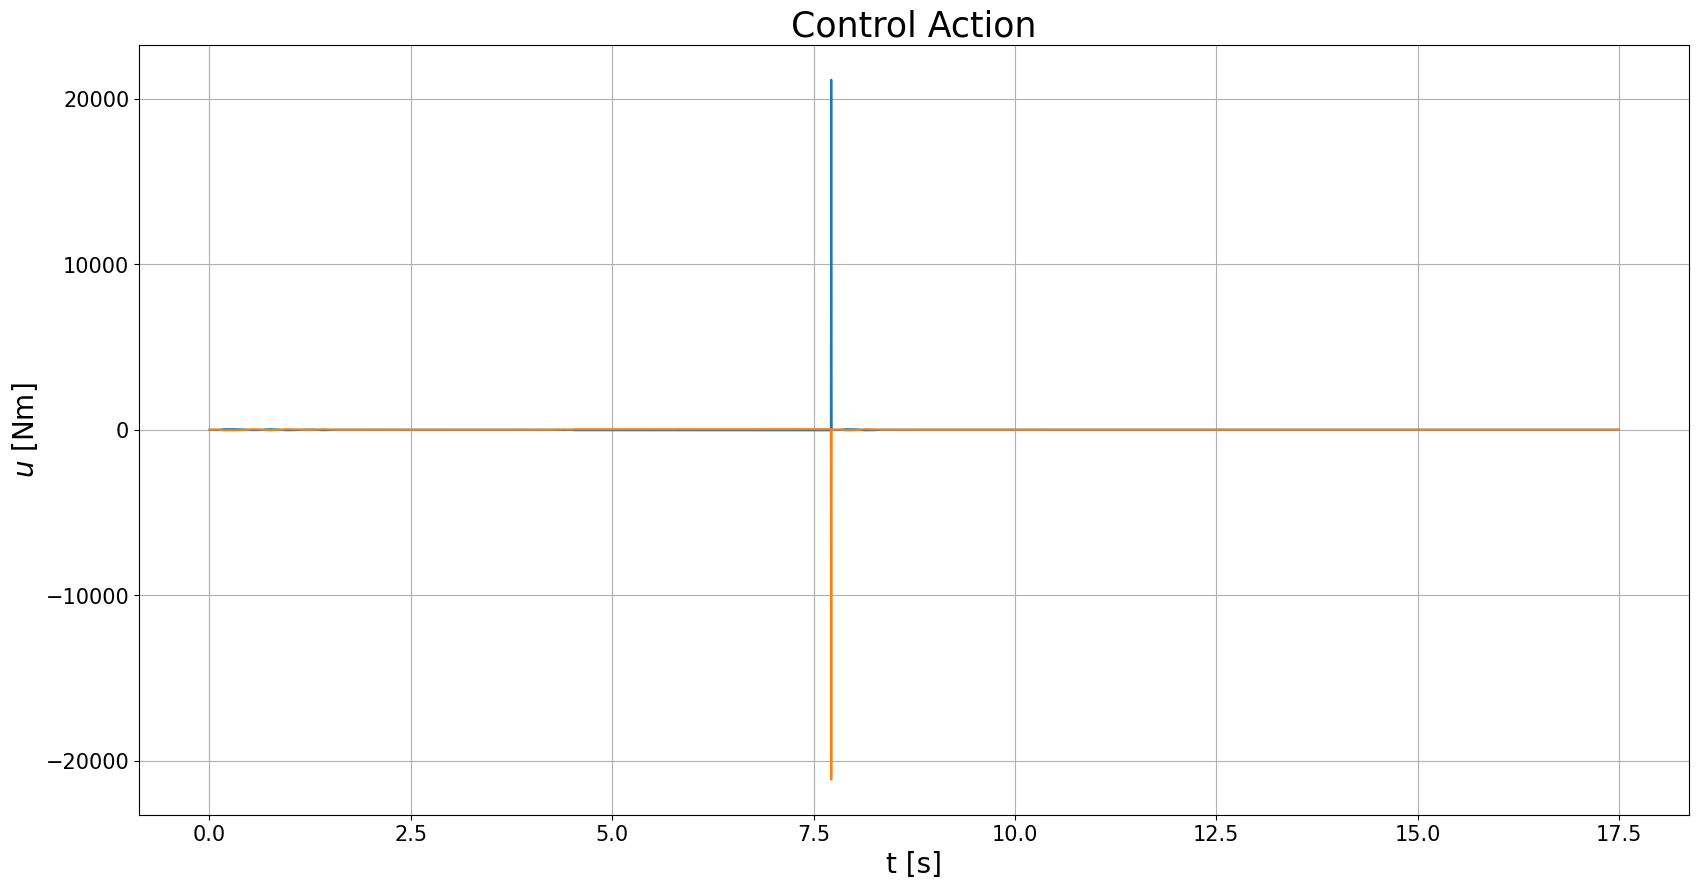

In [22]:
plt.figure(figsize=(20,10))
plt.plot(t_vector, u_vector[0])
plt.plot(t_vector, u_vector[1])
plt.xlabel('t [s]', fontsize=20)
plt.ylabel(r'$u$ [Nm]', fontsize=20)
plt.grid(True)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.title("Control Action", fontsize=25)
plt.show()

In [23]:
np.asarray(real_x_vector[1]).shape

(3500,)

In [24]:
np.asarray(x_hat_lkf_vector[1]).shape
len(x_hat_lkf_vector[1])

3500

Text(0.5, 1.0, '$d\\phi$')

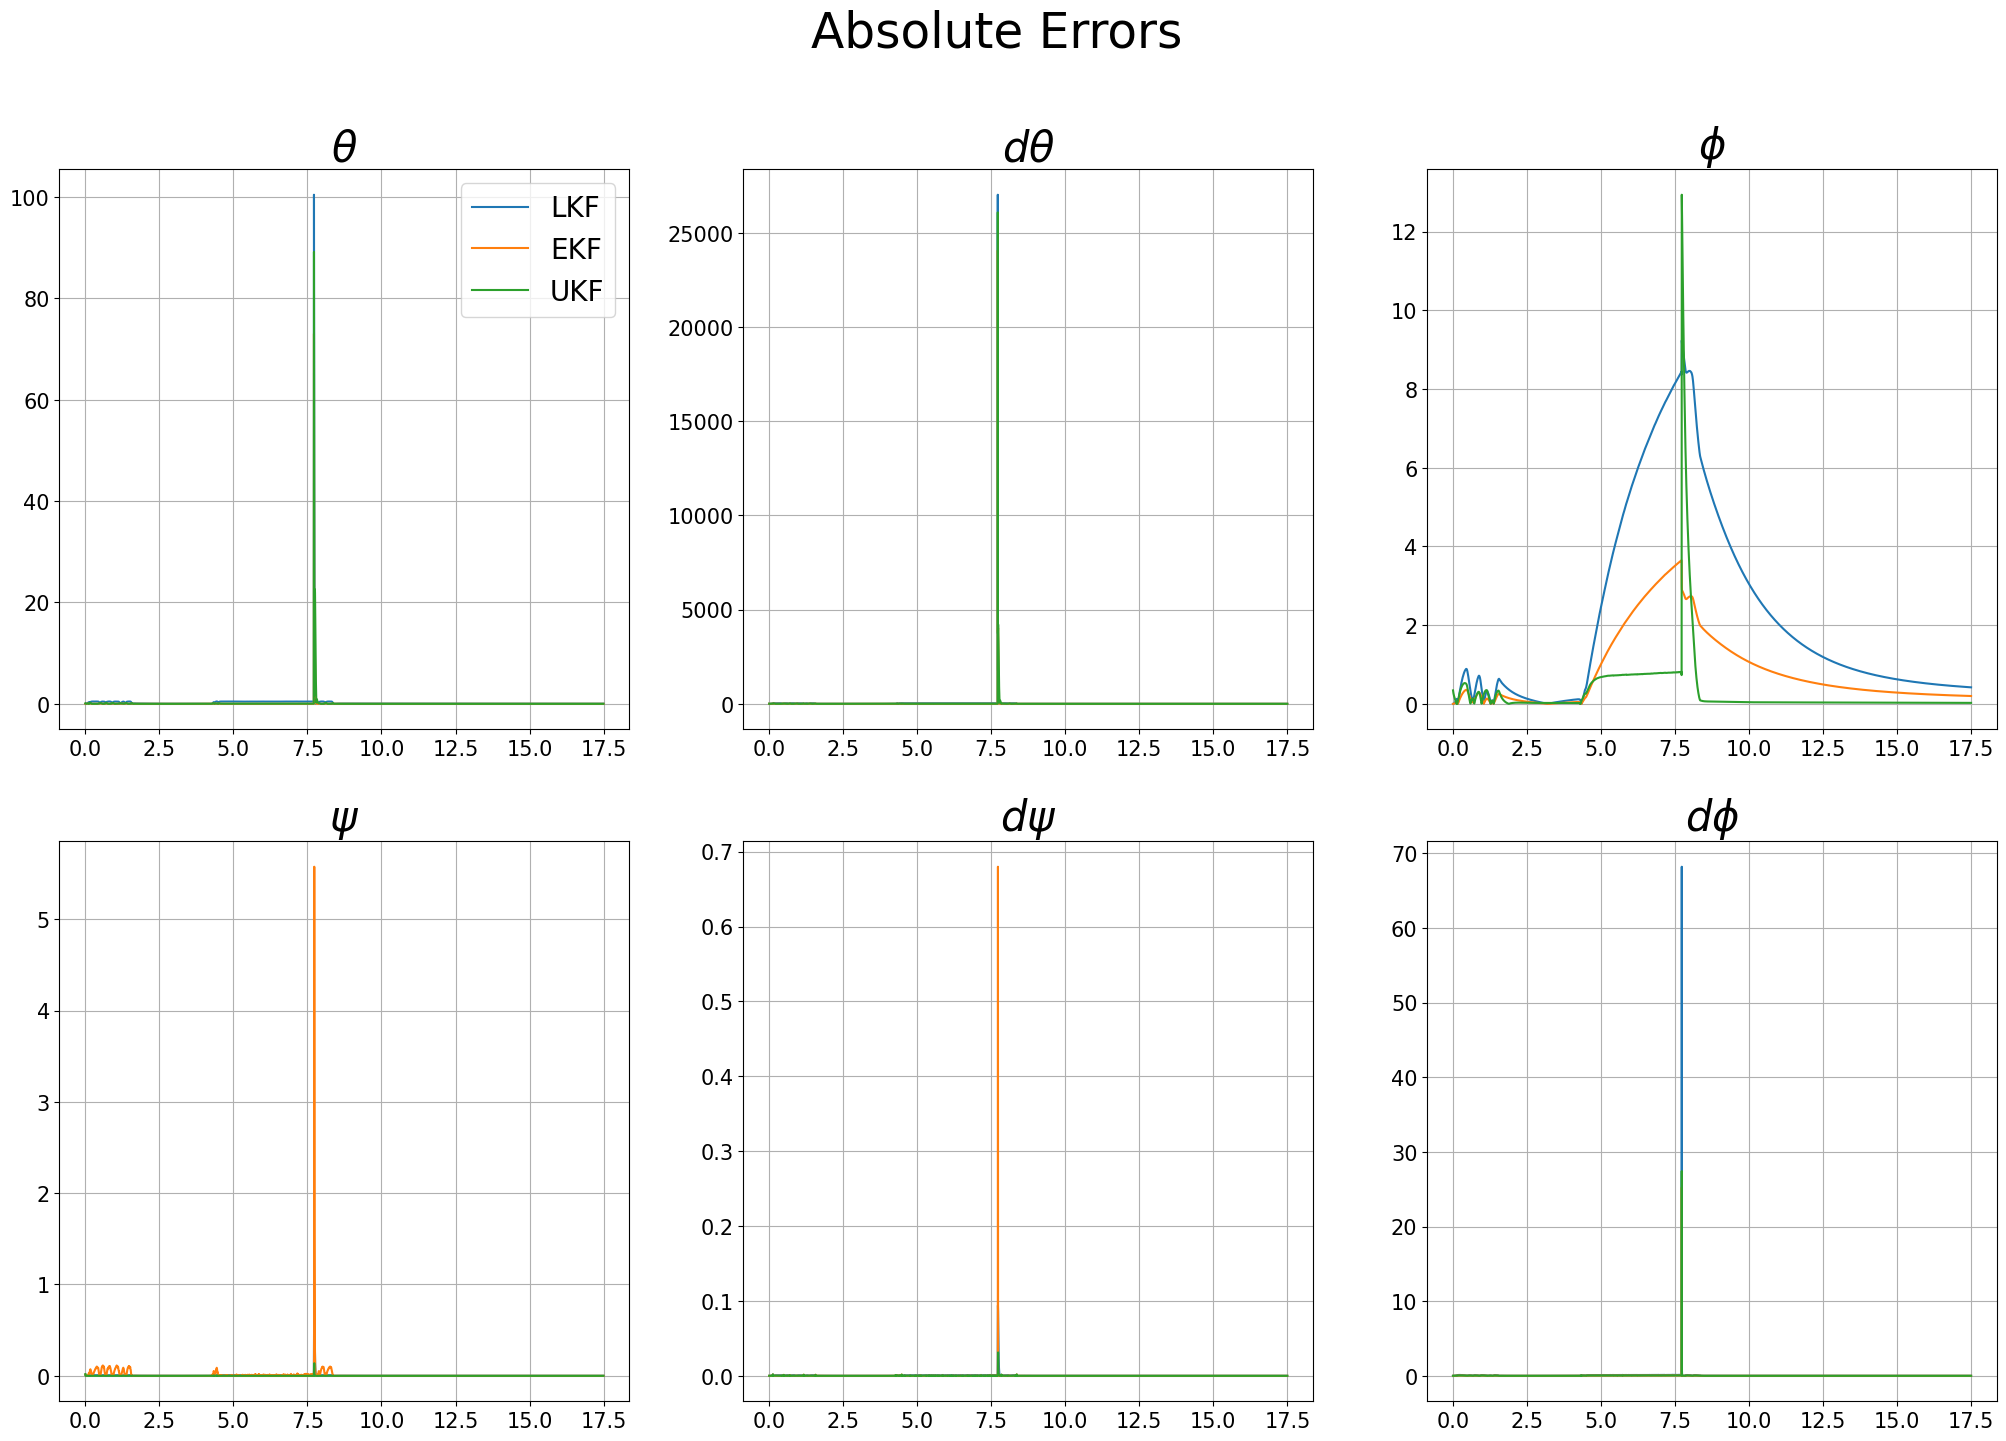

In [25]:
# Filters absolute error
for i in range(dim_x):
    lkf_abs_err_vector[i] = np.abs(list(np.array(real_x_vector[i]) - np.asarray(x_hat_lkf_vector[i]).reshape(len(x_hat_lkf_vector[i]),)))
    ekf_abs_err_vector[i] = np.abs(list(np.array(real_x_vector[i]) - np.asarray(x_hat_ekf_vector[i]).reshape(len(x_hat_ekf_vector[i]),)))
    ukf_abs_err_vector[i] = np.abs(list(np.array(real_x_vector[i]) - np.asarray(x_hat_ukf_vector[i]).reshape(len(x_hat_ukf_vector[i]),)))
    
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 16))
fig.suptitle('Absolute Errors', fontsize="35")

ax1.plot(t_vector, lkf_abs_err_vector[1], label="LKF")
ax1.plot(t_vector, ekf_abs_err_vector[1], label="EKF")
ax1.plot(t_vector, ukf_abs_err_vector[1], label="UKF")
ax1.grid()
ax1.set_title(r'$\theta$', fontsize="30")
ax1.legend(fontsize="20")

ax2.plot(t_vector, lkf_abs_err_vector[3], label="LKF")
ax2.plot(t_vector, ekf_abs_err_vector[3], label="EKF")
ax2.plot(t_vector, ukf_abs_err_vector[3], label="UKF")
ax2.grid()
ax2.set_title(r'$d\theta$', fontsize="30")

ax3.plot(t_vector, lkf_abs_err_vector[5], label="LKF")
ax3.plot(t_vector, ekf_abs_err_vector[5], label="EKF")
ax3.plot(t_vector, ukf_abs_err_vector[5], label="UKF")
ax3.grid()
ax3.set_title(r'$\phi$', fontsize="30")

ax4.plot(t_vector, lkf_abs_err_vector[2], label="LKF")
ax4.plot(t_vector, ekf_abs_err_vector[2], label="EKF")
ax4.plot(t_vector, ukf_abs_err_vector[2], label="UKF")
ax4.grid()
ax4.set_title(r'$\psi$', fontsize="30")

ax5.plot(t_vector, lkf_abs_err_vector[4], label="LKF")
ax5.plot(t_vector, ekf_abs_err_vector[4], label="EKF")
ax5.plot(t_vector, ukf_abs_err_vector[4], label="UKF")
ax5.grid()
ax5.set_title(r'$d\psi$', fontsize="30")

ax6.plot(t_vector, lkf_abs_err_vector[6], label="LKF")
ax6.plot(t_vector, ekf_abs_err_vector[6], label="EKF")
ax6.plot(t_vector, ukf_abs_err_vector[6], label="UKF")
ax6.grid()
ax6.set_title(r'$d\phi$', fontsize="30")


In [26]:
# Mean Squared Errors and Mean Absolute Error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

OKGREEN = '\033[92m'
ENDC = '\033[0m'

lkf_rmse = [[],[],[],[],[],[],[]]
ekf_rmse = [[],[],[],[],[],[],[]]
ukf_rmse = [[],[],[],[],[],[],[]]

lkf_mae = [[],[],[],[],[],[],[]]
ekf_mae = [[],[],[],[],[],[],[]]
ukf_mae = [[],[],[],[],[],[],[]]

for i in range(dim_x):
    lkf_rmse[i] = mean_squared_error(real_x_vector[i], x_hat_lkf_vector[i], squared = False)
    ekf_rmse[i] = mean_squared_error(real_x_vector[i], x_hat_ekf_vector[i], squared = False)
    ukf_rmse[i] = mean_squared_error(real_x_vector[i], x_hat_ukf_vector[i], squared = False)

for i in range(dim_x):
    lkf_mae[i] = mean_absolute_error(real_x_vector[i], x_hat_lkf_vector[i])
    ekf_mae[i] = mean_absolute_error(real_x_vector[i], x_hat_ekf_vector[i])
    ukf_mae[i] = mean_absolute_error(real_x_vector[i], x_hat_ukf_vector[i])

vars = ["i_theta", "theta  ", "psi    ", "d_theta", "d_psi  ", "phi    ", "d_phi  "]

print(f"-----------------------------------")
print(f"|     Root Mean Equared Error     |")
print(f"-----------------------------------")
print(f"|         |  LKF  |  EKF  |  UKF  |")
print(f"-----------------------------------")
for i in range(dim_x):
    min_value = min([lkf_rmse[i], ekf_rmse[i], ukf_rmse[i]])
    min_index = [lkf_rmse[i], ekf_rmse[i], ukf_rmse[i]].index(min_value)
    if min_index == 0:
        print(f"| {vars[i]} | {OKGREEN}{lkf_rmse[i]:.3f}{ENDC} | {ekf_rmse[i]:.3f} | {ukf_rmse[i]:.3f} |")
    elif min_index == 1:
        print(f"| {vars[i]} | {lkf_rmse[i]:.3f} | {OKGREEN}{ekf_rmse[i]:.3f}{ENDC} | {ukf_rmse[i]:.3f} |")
    elif min_index == 2:
        print(f"| {vars[i]} | {lkf_rmse[i]:.3f} | {ekf_rmse[i]:.3f} | {OKGREEN}{ukf_rmse[i]:.3f}{ENDC} |")
    print(f"-----------------------------------")

print("\n\n")

print(f"-----------------------------------")
print(f"|       Mean Absolute Error       |")
print(f"-----------------------------------")
print(f"|         |  LKF  |  EKF  |  UKF  |")
print(f"-----------------------------------")
for i in range(dim_x):
    min_value = min([lkf_mae[i], ekf_mae[i], ukf_mae[i]])
    min_index = [lkf_mae[i], ekf_mae[i], ukf_mae[i]].index(min_value)
    if min_index == 0:
        print(f"| {vars[i]} | {OKGREEN}{lkf_mae[i]:.3f}{ENDC}  | {ekf_mae[i]:.3f} | {ukf_mae[i]:.3f} |")
    elif min_index == 1:
        print(f"| {vars[i]} | {lkf_mae[i]:.3f}  | {OKGREEN}{ekf_mae[i]:.3f}{ENDC} | {ukf_mae[i]:.3f} |")
    elif min_index == 2:
        print(f"| {vars[i]} | {lkf_mae[i]:.3f}  | {ekf_mae[i]:.3f} | {OKGREEN}{ukf_mae[i]:.3f}{ENDC} |")
    print(f"-----------------------------------")


-----------------------------------
|     Root Mean Equared Error     |
-----------------------------------
|         |  LKF  |  EKF  |  UKF  |
-----------------------------------
| i_theta | 0.185 | 0.186 | 0.186 |
-----------------------------------
| theta   | 2.287 | 1.393 | 1.944 |
-----------------------------------
| psi     | 0.023 | 0.114 | 0.003 |
-----------------------------------
| d_theta | 460.160 | 425.797 | 467.942 |
-----------------------------------
| d_psi   | 0.003 | 0.011 | 0.001 |
-----------------------------------
| phi     | 3.333 | 1.287 | 1.015 |
-----------------------------------
| d_phi   | 1.154 | 0.427 | 0.464 |
-----------------------------------



-----------------------------------
|       Mean Absolute Error       |
-----------------------------------
|         |  LKF  |  EKF  |  UKF  |
-----------------------------------
| i_theta | 0.106  | 0.107 | 0.106 |
-----------------------------------
| theta   | 0.230  | 0.055 | 0.104 |
-----------------

/home/yoggi/gyrobro_ws/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/yoggi/gyrobro_ws/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/yoggi/gyrobro_ws/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/yoggi/gyrobro_ws/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

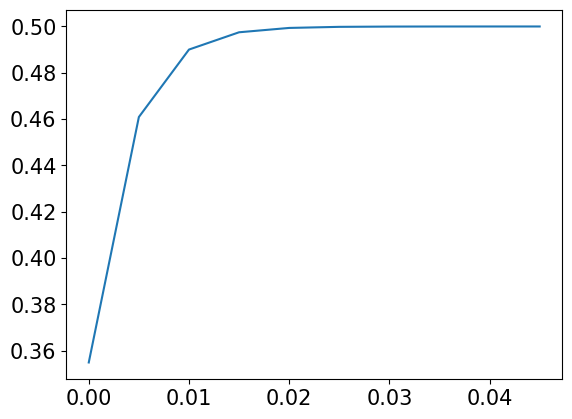

In [27]:
plt.plot(t_vector[:10], K_lkf_vector[:10])

In [28]:
env.close()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
